<a href="https://colab.research.google.com/github/hansong0219/Advanced-DeepLearning-Study/blob/master/auto_encoder/Coloration_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

채색 오토 인코더
----
다음 코드에서는 오토 인코더를 활용하여, 잠재 벡터로 변경된 흑백 사진을 R,G,B 의 컬러 사진으로 변환하는 모델을 구현한다. 
해당 모델을 구현하기 위해서 CIFAR10 데이터 베이스를 우선, 흑백으로 변경해 주고 입력으로 설정한 후 출력을 원본 이미지로 학습하는 모델을 구성한다.

In [1]:
#필요 모듈 불러오기
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten 
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

데이터 셋 전처리
-----

In [2]:
# 이미지 변환 함수 정의 
def rgb2gray(rgb):
  return np.dot(rgb[...,:3],[0.299, 0.587, 0.114])

In [3]:
#CIFAR10 데이터 로딩
(x_train,_),(x_test,_) = cifar10.load_data()

In [4]:
#입력 이미지 차원 - 데이터 형식이 마지막에 채널이 온다고 가정함
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

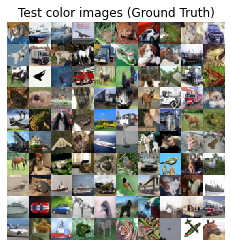

In [5]:
# 입력 이미지 표시 및 확인
imgs = x_test[:100]
imgs = imgs.reshape((10,10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation = 'none')
plt.show()

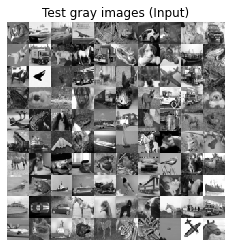

In [6]:
# 이미지 흑백 변환 및 입력 이미지 표시 및 확인
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

imgs = x_test_gray[:100]
imgs = imgs.reshape((10,10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation = 'none',cmap='gray')
plt.show()

In [7]:
# 데이터 정규화
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train_gray = x_train_gray.astype('float32')/255
x_test_gray = x_test_gray.astype('float32')/255

In [8]:
# CNN 출력/ 검증을 위한 이미지 형상 변경
x_train = x_train.reshape(x_train.shape[0], img_rows,img_cols,channels)
x_test = x_test.reshape(x_test.shape[0], img_rows,img_cols,channels)
# 입력을 위한 변경
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows,img_cols,1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows,img_cols,1)

모델 구성
-----

In [10]:
#네트워크 매개 변수
input_shape = (img_rows, img_cols,1)
batch_size = 32
kernel_size = 3
latent_dim = 256

#CNN 계층의 인코더/디코더 개수와 계층별 필터수
layer_filters = [64, 128, 256]

In [11]:
# 인코더 모델구성
inputs = Input(shape=input_shape,name = 'encoder_input')
x = inputs 

# Conv2D(64) - Conv2D(128) - Conv2D(256) 모델 스택
for filters in layer_filters:
  x = Conv2D(filters = filters,
             kernel_size = kernel_size,
             strides = 2,
             activation = 'relu',
             padding = 'same')(x)

#디코더 모델 구성을 위한 정보획득 
shape = K.int_shape(x)

# CNN 층 이후의 인코더 층 구성
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

In [12]:
# 인코더 모델 인스턴스화
encoder = Model(inputs, latent, name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               1048832   
Total params: 1,418,496
Trainable params: 1,418,496
Non-trainable params: 0
_________________________________________________

In [13]:
# 디코더 모델 구성
latent_inputs = Input(shape = (latent_dim), name = 'latent_vector')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

#Conv2DTranpose(256) - Conv2DTranspose(128) - Conv2DTranspose(64) 스택
for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters = filters,
                      kernel_size = kernel_size,
                      strides = 2,
                      activation = 'relu',
                      padding = 'same')(x)

outputs = Conv2DTranspose(filters = channels,
                          kernel_size = kernel_size,
                          activation = 'sigmoid',
                          padding = 'same',
                          name = 'decode_output')(x)

In [14]:
# 디코더 모델 인스턴스화 
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_vector (InputLayer)   [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1052672   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        73792     
_________________________________________________________________
decode_output (Conv2DTranspo (None, 32, 32, 3)         1731

In [15]:
# 오토인코더 모델 인스턴스화 
autoencoder = Model(inputs, decoder(encoder(inputs)), name='same')
autoencoder.summary()

Model: "same"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 256)               1418496   
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         2013315   
Total params: 3,431,811
Trainable params: 3,431,811
Non-trainable params: 0
_________________________________________________________________


In [16]:
# 손실이 5 epoch 내에 개선되지 않으면, 학습속도를 sqrt(0.1)을 사용해 감소시킴
Ir_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 5,
                               verbose = 1,
                               min_Ir = 0.5e-6)

In [17]:
autoencoder.compile(loss = 'mse', optimizer = 'adam')
callback = [Ir_reducer]

In [18]:
autoencoder.fit(x_train_gray,x_train,validation_data=(x_test_gray,x_test),epochs=30, batch_size=batch_size,callbacks=callback)

Epoch 1/30
1563/1563 [==============================] - 564s 361ms/step - loss: 0.0152 - val_loss: 0.0107
Epoch 2/30
1563/1563 [==============================] - 559s 357ms/step - loss: 0.0101 - val_loss: 0.0096
Epoch 3/30
1563/1563 [==============================] - 559s 358ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 4/30
1563/1563 [==============================] - 561s 359ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 5/30
1563/1563 [==============================] - 563s 360ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 6/30
1563/1563 [==============================] - 565s 361ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 7/30
1563/1563 [==============================] - 563s 360ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 8/30
1563/1563 [==============================] - 562s 359ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 9/30
1563/1563 [==============================] - 567s 362ms/step - loss: 0.0071 - val_loss: 0.0077
Epoch 10/30
1563/1563 [=======================

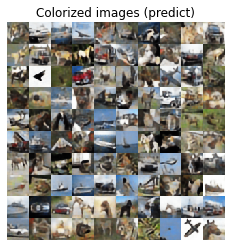

In [21]:
x_decoded = autoencoder.predict(x_test_gray)
imgs = x_decoded[:100]
imgs = imgs.reshape((10,10,img_rows,img_cols,channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

plt.figure()
plt.axis('off')
plt.title('Colorized images (predict)')
plt.imshow(imgs, interpolation = 'none')
plt.show()